# MITGCM Regional Time Scale Analysis 

**Purpose**: Code for preforming the regional time scale analysis. I will compute the decorrelation time scale for a subset of the model domain at each grid point. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [ ]:
%matplotlib inline

: 

Import python libraries

In [ ]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean

# Set path to access python functions
sys.path.append("/home/lcolosi/AirSeaCoupling/tools/")

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from spectra import spectrum1D_frequency
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc

: 

Set data analysis parameters

In [ ]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density

# Set time and space parameters
T            = 1*(60)*(60)                   # Spcifies the time interval for model run. Units: seconds
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function    
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze

# Set path to project directory
PATH = "/data/SO3/lcolosi/mitgcm/SWOT_MARA_RUN4_LY/"
PATH_figs = "/home/lcolosi/AirSeaCoupling/figs_server/mitgcm/scale_analysis/"
PATH_bathy  = '/data/SO3/lcolosi/bathymetry/'

# Set plotting parameters 
fontsize = 16

: 

Load mitgcm data netcdf files 

In [ ]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename = PATH + "THETA_CCS4_hrly_ts_ext.nc"
elif option_var == 'sal':
    filename = PATH + "SALT_CCS4_hrly_ts_ext.nc"
elif option_var == 'density':
    filename = PATH + "RHO_CCS4_hrly_ts_ext.nc"
nc = Dataset(filename, 'r')

# Extract data variables
water_depth   = nc.variables['Depth'][:]

lon = nc.variables['XC'][:]
lat = nc.variables['YC'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

if option_var == 'temp':
    data = nc.variables['THETA'][:]
elif option_var == 'sal':
    data = nc.variables['SALT'][:]
elif option_var == 'density':
    data = nc.variables['RHO'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

: 

Read in bathymetry data

In [ ]:
# Load bathymetry data 
filename = PATH_bathy + "topo_25.1.nc"
ds_bathy = xr.open_dataset(filename, engine="netcdf4")

# Extract data variables
lon_b = ds_bathy["lon"]  # Longitude
lat_b = ds_bathy["lat"]  # Latitude
bathy = ds_bathy["z"]    # Elevation/Bathymetry

# Convert convesion of longitude (neg from the prime meridian to positive definite wrapping around the earth)
lon_n = lon_b % 360

# Set max and min values 
lon_min = lon_bnds[0]
lon_max = lon_bnds[1]
lat_min = lat_bnds[0]
lat_max = lat_bnds[1]

# Extract data from bathymetry 
lon_grid = lon_n[(lon_n >= lon_min) & (lon_n <= lon_max)]
lat_grid = lat_b[(lat_b >= lat_min) & (lat_b <= lat_max)]
bathy_grid   = bathy[(lat_b >= lat_min) & (lat_b <= lat_max),(lon_n >= lon_min) & (lon_n <= lon_max)]

: 

Plot the spatial domain

In [ ]:
# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-123, -122, -121, -120]
yticks = [33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75, 35.00]
resolution = "10m"
bounds = np.arange(0,360+40,40)
lon_min = -123
lon_max = -120
lat_min = 33
lat_max = 35

# Specify data specific attributes 
if option_var == 'temp':
    cmap = 'RdYlBu_r'
    label = r'Temperature ($^\circ$C)'
    levels = np.arange(13,17,0.1)
elif option_var == 'sal':
    cmap = 'BrBG_r'
    label = r'Salinity (psu)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    cmap = 'Spectral_r'
    label = r'$\sigma_0$ (kg m$^{-3}$)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, data[1,:,:], levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmap,  
    shading="auto"
)

# Plot depth contour lines
levels_bath = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_bath, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=14)
plt.clabel(contour2, fontsize=14)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=label,
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure
fig.savefig(fname = PATH_figs + 'Temperature_spatial_map_ts', bbox_inches = 'tight', dpi=300)

: 

Preform scale analysis

In [ ]:
# Set parameters
incr = 3
ntime,nlat,nlon = np.shape(data)
nlat_s, nlon_s = int(np.floor(nlat/incr)), int(np.floor(nlon/incr))
lag = ntime
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/hr

# Convert to seconds since start time
t0 = time_dt[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time_dt])

# Initialize arrays 
autocorr = np.zeros((ntime,nlat_s,nlon_s))
time_scale = np.zeros((ntime,nlat_s,nlon_s))
delta_t = np.zeros((nlat_s,nlon_s))
phase_a = np.zeros((nlat_s,nlon_s))
phase_sa = np.zeros((nlat_s,nlon_s))
amp_a = np.zeros((nlat_s,nlon_s))
amp_sa = np.zeros((nlat_s,nlon_s))
rms = np.zeros((nlat_s,nlon_s))
fve = np.zeros((nlat_s,nlon_s))
sigma_phase_a = np.zeros((nlat_s,nlon_s))
sigma_phase_sa = np.zeros((nlat_s,nlon_s))
sigma_amp_a = np.zeros((nlat_s,nlon_s))
sigma_amp_sa = np.zeros((nlat_s,nlon_s))
cn_lon = 0 

# Loop through longitude 
for ilon in range(0,nlon-1,incr):
    print((ilon/nlon)*100)

    # Set latitude counter 
    cn_lat = 0

    # Loop through latitude
    for ilat in range(0,nlat-1,incr):
        
        # Initialize the ith time series 
        data_ts = data[:,ilat,ilon]

        # Remove annual and semi-annual cycle 
        hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
        data_ts_rm = data_ts - hfit

        # Compute the rmse, phase and amplitude of the annual and semi-annual cycles and their uncertainities
        _, rms[cn_lat,cn_lon], fve[cn_lat,cn_lon], iamp, iphase = compute_amp_phase(data, hfit, x_data, parameters = 2)
        isigma_amp, isigma_phase = compute_amp_phase_unc(x_data, x_data_sigma, parameters = 2)

        # Save the phase and amplitude plus their uncertainties to the arrays
        phase_a[cn_lat,cn_lon], phase_sa[cn_lat,cn_lon] = iphase[0], iphase[1]
        amp_a[cn_lat,cn_lon], amp_sa[cn_lat,cn_lon] = iamp[0], iamp[1]
        sigma_phase_a[cn_lat,cn_lon], sigma_phase_sa[cn_lat,cn_lon] = isigma_phase[0], isigma_phase[1]
        sigma_amp_a[cn_lat,cn_lon], sigma_amp_sa[cn_lat,cn_lon] = isigma_amp[0], isigma_amp[1]

        # Compute autocorrelation function
        autocorr[:,cn_lat,cn_lon], _, _, _, time_scale[:,cn_lat,cn_lon], _ = compute_autocorr(data_ts_rm, time_elapsed, lag, estimator, 0)

        # Compute the decorrelation scale
        delta_t[cn_lat,cn_lon] = compute_decor_scale(autocorr[:,cn_lat,cn_lon],time_scale[:,cn_lat,cn_lon],T,estimator,0)

        # Compute frequency power spectrum 
        

        # Compute structure function


        # Set latitude counter
        cn_lat = cn_lat + 1

    # Set longitude counter
    cn_lon = cn_lon + 1

# Convert time scale to units of months
delta_ts = delta_t*(1/60)*(1/60)*(1/24)*(1/30)


TypeError: 'numpy.float64' object cannot be interpreted as an integer

(36,)
(24,)
(24, 36)


/home/lcolosi/miniconda3/envs/ccs_scale/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


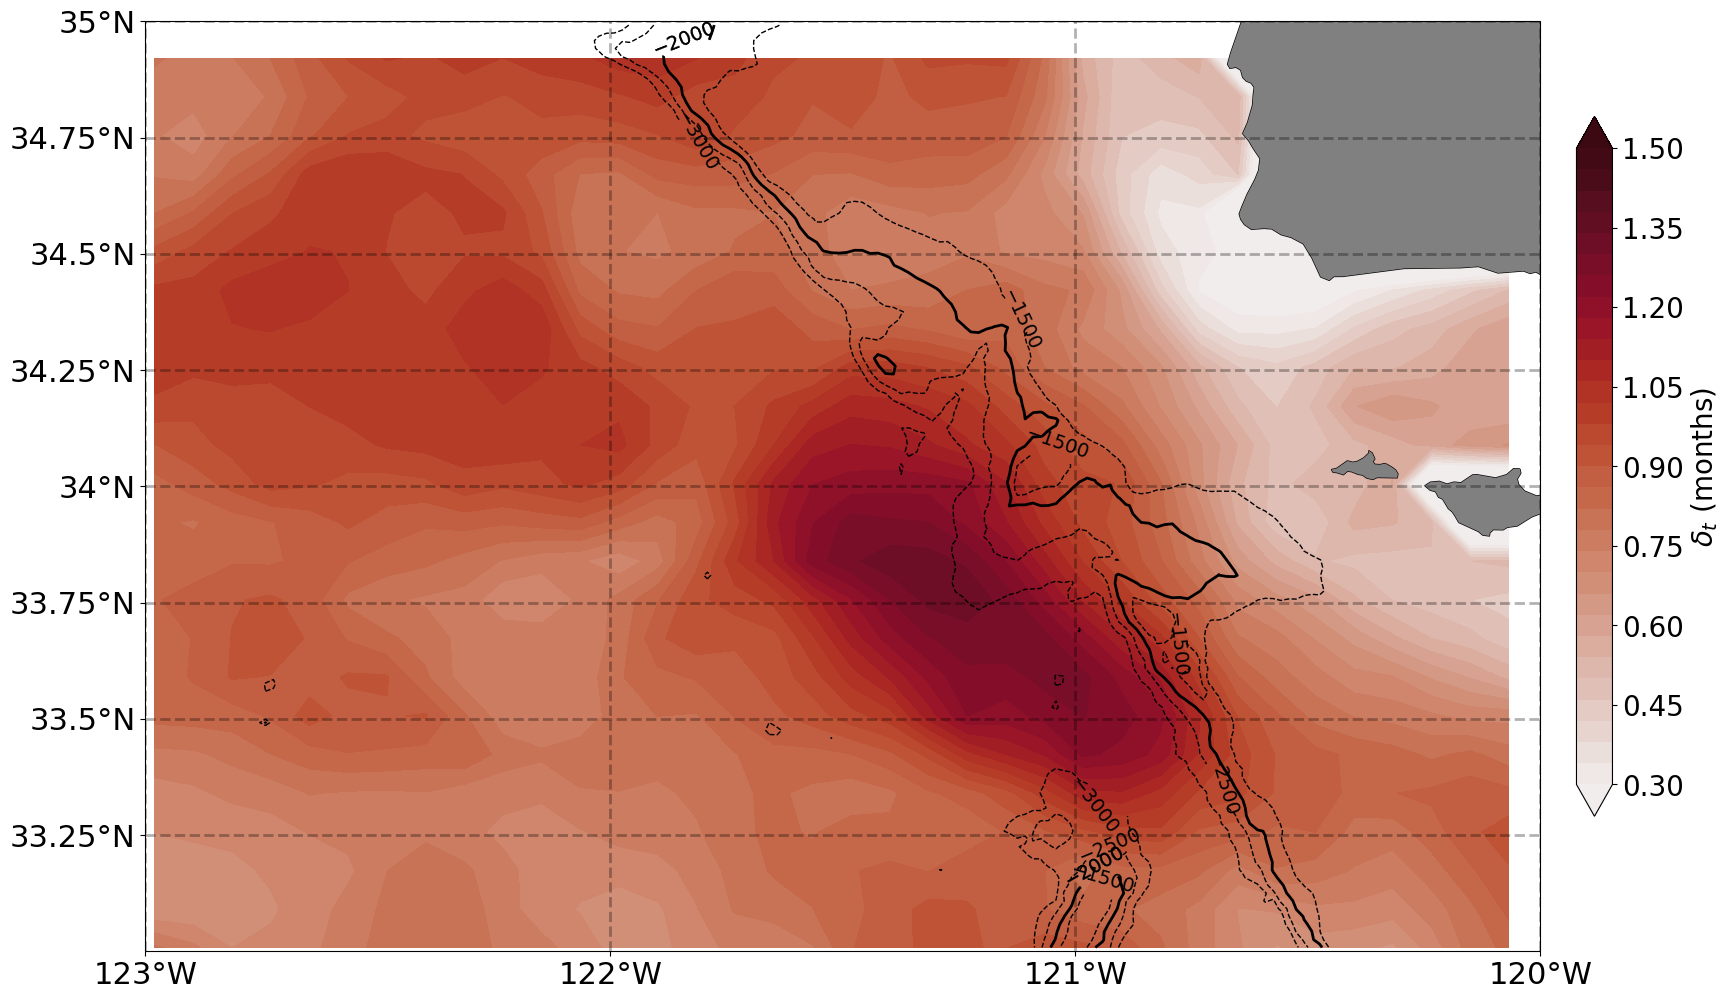

In [44]:
# Set plotting parameters 
levels = np.arange(0.30,1.5 + 0.04,0.04) #np.arange(0.2,1.5,0.01)

# Redefine longitude and latitude
lon_ds = lon[::4]
lat_ds = lat[::4]

# Reslice delta array
delta_ds = delta_ts[0:len(lat_ds),0:len(lon_ds)]

print(np.shape(lon_ds))
print(np.shape(lat_ds))
print(np.shape(delta_ds))

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot potential temperature
mesh = axes.contourf(
    lon_ds, lat_ds, delta_ds, levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
levels_bath = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_bath, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=14)
plt.clabel(contour2, fontsize=14)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'$\delta_t$ (months)',
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH_figs + 'time_decorr_scale_' + option_var + 'spatial_map_' + str(incr), bbox_inches = 'tight', dpi=300)


Save intermediate data 